### Do not run the first 3 cells if this notebook is not at the Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration"
!ls

/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration
 affineRegNN2_debug.ipynb	    data
 affineRegNN3_data1_svd_rot.ipynb   generate_data2.m
 affineRegNN4.5_data_toy.ipynb	    layers.py
 affineRegNN4_data2.ipynb	    model_img
 affineRegNN5_data3.ipynb	    MRNet
 affineRegNN_archive.ipynb	    prototype.py
 affine_training_data_gen.ipynb     __pycache__
 baseline_DLIR_v2.png		    utils.py
 checkpoints			   'VoxelMorph Demo.ipynb'


In [3]:
!pip install neurite

     |████████████████████████████████| 86 kB 4.4 MB/s 


In [4]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import math

import layers as custom_layers

In [5]:
fixed_img_ph = np.zeros((64, 256, 256))
fixed_img_ph[3:60, 29:225, 29:225] = 1
fixed_img_ph = np.asarray(fixed_img_ph).astype(np.float32)

In [6]:
fixed_img_ph = np.expand_dims(fixed_img_ph, axis=-1)
fixed_img_ph = np.expand_dims(fixed_img_ph, axis=0)

In [7]:
# Get rid of the batch dimension
img_input = keras.Input(shape = list(fixed_img_ph.shape)[1:])
affine_input = keras.Input(shape = (12,))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, shift_center=True)([img_input, affine_input])
print(affine_warped.shape)

Instructions for updating:
Use fn_output_signature instead
(None, 64, 256, 256, 1)


In [8]:
print(img_input.shape)

(None, 64, 256, 256, 1)


In [9]:
model = keras.Model(inputs=[img_input, affine_input], outputs=affine_warped, name="affine_transformation")
model.summary(line_length=150)

Model: "affine_transformation"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 64, 256, 256, 1)]        0                 []                                                
                                                                                                                                                      
 input_2 (InputLayer)                            [(None, 12)]                     0                 []                                                
                                                                                                                                                      
 spatial_transformer (SpatialTransformer)        (None, 64, 256

In [10]:
def random_transform(fixed_img):
    '''
    Takes a fixed image and apply random affine transformation to it.
    
    fixed_img: Tensor: shape (1, W, H, D, 1)
    
    return: warped_img:  Tensor: shape(1, W, H, D, 1)
            affine_param: ndarray: shape: (12,), this is the transformation parameter
                                   we need to transform moving image back to the fixed image. 
    '''
    translation = np.eye(4)
    rotX = np.eye(4)
    rotY = np.eye(4)
    rotZ = np.eye(4)
    scaling = np.eye(4)

    # Constants
    xTranslationRange = 5
    yTranslationRange = 30
    zTranslationRange = 30
    xRotAngle = math.pi / random.uniform(8, 80)
    yRotAngle = math.pi / random.uniform(40, 160)
    zRotAngle = math.pi / random.uniform(40, 160)
    scalingX = random.uniform(0.85, 1.15)
    scalingY = random.uniform(0.85, 1.15)
    scalingZ = random.uniform(0.85, 1.15)
    
    # Calculate affine transformation matrix
    translation[0, 3] = xTranslationRange * random.random()
    translation[1, 3] = yTranslationRange * random.random()
    translation[2, 3] = zTranslationRange * random.random()

    rotX[1, 1] = math.cos(xRotAngle)
    rotX[1, 2] = math.sin(xRotAngle)
    rotX[2, 1] = -math.sin(xRotAngle)
    rotX[2, 2] = math.cos(xRotAngle)

    rotY[0, 0] = math.cos(yRotAngle)
    rotY[0, 2] = -math.sin(yRotAngle)
    rotY[2, 0] = math.sin(yRotAngle)
    rotY[2, 2] = math.cos(yRotAngle)

    rotZ[0, 0] = math.cos(zRotAngle)
    rotZ[0, 1] = -math.sin(zRotAngle)
    rotZ[1, 0] = math.sin(zRotAngle)
    rotZ[1, 1] = math.cos(zRotAngle)

    scaling[0, 0] = scalingX
    scaling[1, 1] = scalingY
    scaling[2, 2] = scalingZ

    transMat = translation @ rotZ @ rotY @ rotX @ scaling

    # Affine transformation parameters to feed into VoxelMorph's transformation layer.
    affine_param = transMat[0:3].flatten()
    affine_param = np.expand_dims(affine_param, axis=0)

    warped_img = model([fixed_img, affine_param])
    
    transMat_inv = np.linalg.inv(transMat)
    affine_param_inv = transMat_inv[0:3].flatten().astype(np.float32)
    
    return warped_img, affine_param_inv

### For testing purposes: check random transformed image samples

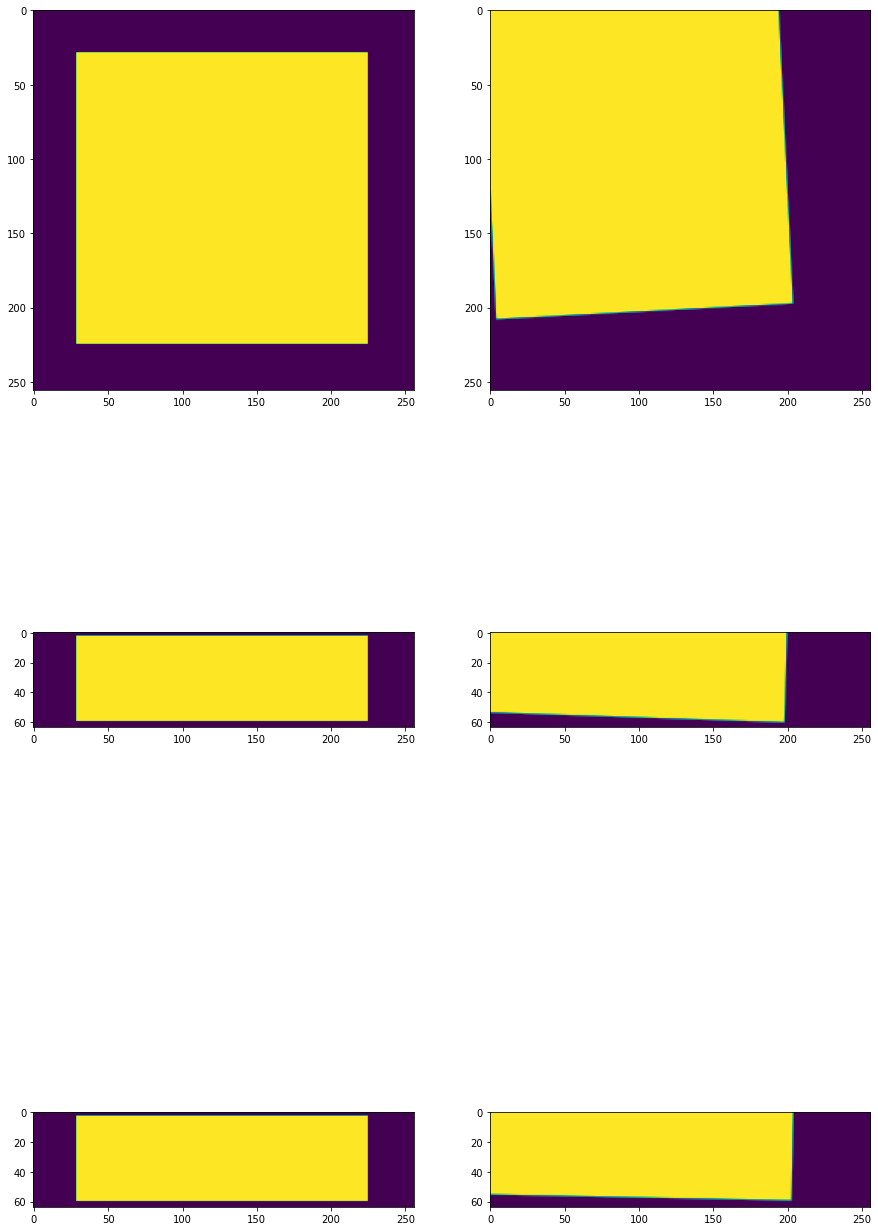

In [ ]:
warped_img_test, _ = random_transform(fixed_img_ph)
sliceToCheck_x = 25
sliceToCheck_y = 100
sliceToCheck_z = 100
fig, axs = plt.subplots(3, 2, figsize=(15, 25))
axs[0, 0].imshow(fixed_img_ph[0, sliceToCheck_x, :, :, 0])
axs[0, 1].imshow(warped_img_test[0, sliceToCheck_x, :, :, 0])
axs[1, 0].imshow(fixed_img_ph[0, :, sliceToCheck_y, :, 0])
axs[1, 1].imshow(warped_img_test[0, :, sliceToCheck_y, :, 0])
axs[2, 0].imshow(fixed_img_ph[0, :, :, sliceToCheck_z, 0])
axs[2, 1].imshow(warped_img_test[0, :, :, sliceToCheck_z, 0])
# plt.tight_layout()

### Loop to generate training dataset

In [ ]:
def set_outermost_to_zero(img):
    assert len(img.shape) == 5
    # change the outermost layer to zero to avoid wrong interpolation during affine trans
    img = img[:, 1:-1, 1:-1, 1:-1, :]
    img = np.pad(img, pad_width=((0,0),(1,1),(1,1),(1,1),(0,0)), mode="constant",
                    constant_values=0)
    return img

In [ ]:
single_fixed_img = False # True will make dataset only contain 1 fixed image; False otherwise.
# num_pairs = 50
# output_dir = "./data/ToyTrainingData2"
num_pairs = 500
output_dir = "./data/ToyTrainingData2v2"
os.makedirs(output_dir, exist_ok=True)
path = os.path.join(output_dir, "toy_affine{}.npz")
for i in range(num_pairs):
    fixed_img = fixed_img_ph
    if not single_fixed_img:
        fixed_img, _ = random_transform(fixed_img)
        # fixed_img = set_outermost_to_zero(fixed_img)
    
    warped_img, affine_param = random_transform(fixed_img)
    # warped_img = set_outermost_to_zero(warped_img)

    img_pair = tf.concat([warped_img, fixed_img], axis=-1) # reversed order
    
    f = open(path.format(i), "wb")
    np.savez(f, img_pair = img_pair, trf = affine_param)
    f.close()
    if (i % 10 == 0):
        print("Milestone: file {} has been saved.".format(i))

Milestone: file 0 has been saved.
Milestone: file 10 has been saved.
Milestone: file 20 has been saved.
Milestone: file 30 has been saved.
Milestone: file 40 has been saved.
Milestone: file 50 has been saved.
Milestone: file 60 has been saved.
Milestone: file 70 has been saved.
Milestone: file 80 has been saved.
Milestone: file 90 has been saved.
Milestone: file 100 has been saved.
Milestone: file 110 has been saved.
Milestone: file 120 has been saved.
Milestone: file 130 has been saved.
Milestone: file 140 has been saved.
Milestone: file 150 has been saved.
Milestone: file 160 has been saved.
Milestone: file 170 has been saved.
Milestone: file 180 has been saved.
Milestone: file 190 has been saved.
Milestone: file 200 has been saved.
Milestone: file 210 has been saved.
Milestone: file 220 has been saved.
Milestone: file 230 has been saved.
Milestone: file 240 has been saved.
Milestone: file 250 has been saved.
Milestone: file 260 has been saved.
Milestone: file 270 has been saved.
Mil

### Load and inspect random samples from generated dataset.

In [ ]:
num_pairs = 10
# path = "./data/ToyTrainingData2/toy_affine{}.npz"
path = "./data/ToyTrainingData2v2/toy_affine{}.npz"

(1, 12)
(1, 64, 256, 256, 1)
(1, 64, 256, 256, 1)
(1, 64, 256, 256, 1)


Text(0.5, 1.0, 'recon')

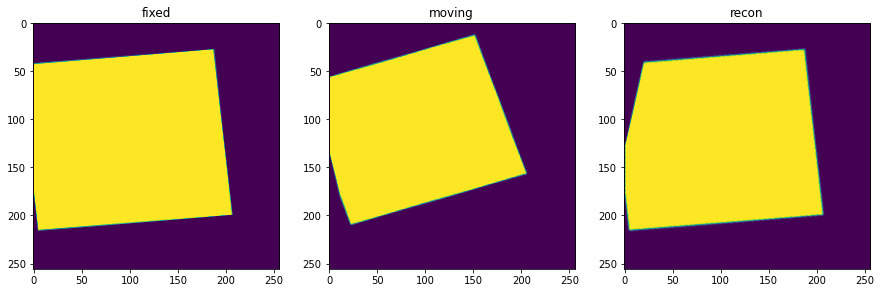

In [ ]:
rand_idx = random.randrange(num_pairs)
sample_obj = np.load(path.format(rand_idx))
img_pair = sample_obj['img_pair']
affine_param = sample_obj['trf'][None,:]

fixed_img_sample = np.expand_dims(img_pair[:, :, :, :, 0], axis=-1)
moving_img_sample = np.expand_dims(img_pair[:, :, :, :, 1], axis=-1)
recon_img_sample = model([moving_img_sample, affine_param])
print(affine_param.shape)
print(fixed_img_sample.shape)
print(moving_img_sample.shape)
print(recon_img_sample.shape)

slice_idx_x = 30
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(fixed_img_sample[0, slice_idx_x, :, :, 0])
axs[0].set_title("fixed")
axs[1].imshow(moving_img_sample[0, slice_idx_x, :, :, 0])
axs[1].set_title("moving")
axs[2].imshow(recon_img_sample[0, slice_idx_x, :, :, 0])
axs[2].set_title("recon")

In [12]:
## check fixed and recon difference
count = 100
mean_mse_init = 0
mean_mse = 0
for i in tqdm(range(count)):
    fixed_img, _ = random_transform(fixed_img_ph)
    # fixed_img = set_outermost_to_zero(fixed_img)
    
    warped_img, affine_param = random_transform(fixed_img)
    # warped_img = set_outermost_to_zero(warped_img)

    diff = ((fixed_img.numpy() - warped_img.numpy())**2).mean()
    mean_mse_init += diff

    recon_img_sample = model([warped_img, affine_param[None,:]])

    diff = ((fixed_img.numpy()- recon_img_sample.numpy())**2).mean()
    mean_mse += diff
print("fixed vs. moving", mean_mse_init/count)
print(mean_mse/count)

  0%|          | 0/100 [00:00<?, ?it/s]

fixed vs. moving 0.14852043218910693
0.025005043509881943


In [ ]:
## check fixed and recon difference with set_outermost_to_zero
count = 100
mean_mse_init = 0
mean_mse = 0
for i in tqdm(range(count)):
    fixed_img, _ = random_transform(fixed_img_ph)
    fixed_img = fixed_img.numpy()
    fixed_img = set_outermost_to_zero(fixed_img)
    
    warped_img, affine_param = random_transform(fixed_img)
    warped_img = warped_img.numpy()
    warped_img = set_outermost_to_zero(warped_img)

    diff = ((fixed_img - warped_img)**2).mean()
    mean_mse_init += diff

    recon_img_sample = model([warped_img, affine_param[None,:]])
    recon_img_sample = recon_img_sample.numpy()

    diff = ((fixed_img - recon_img_sample)**2).mean()
    mean_mse += diff
print("fixed vs. moving", mean_mse_init/count)
print("fixed vs. recon", mean_mse/count)

  0%|          | 0/100 [00:00<?, ?it/s]

fixed vs. moving 0.14852223202586173
fixed vs. recon 0.07532646049279719


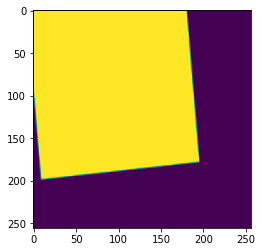

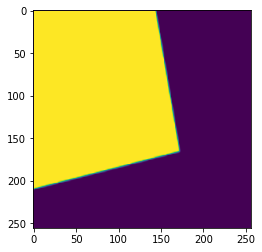

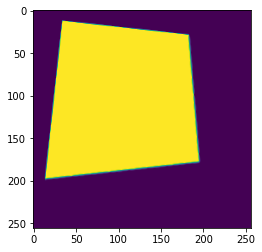

0.11105076223611832


In [ ]:
## check fixed and recon difference
count = 1
mean_mse = 0
for i in range(count):
    fixed_img, _ = random_transform(fixed_img)
    fixed_img = fixed_img.numpy()
    fixed_img = set_outermost_to_zero(fixed_img)
    plt.imshow(fixed_img[0,30,:,:,0])
    plt.show()
    
    warped_img, affine_param = random_transform(fixed_img)
    warped_img = warped_img.numpy()
    warped_img = set_outermost_to_zero(warped_img)
    plt.imshow(warped_img[0,30,:,:,0])
    plt.show()

    recon_img_sample = model([warped_img, affine_param[None,:]])
    recon_img_sample = recon_img_sample.numpy()
    plt.imshow(recon_img_sample[0,30,:,:,0])
    plt.show()

    diff = ((fixed_img- warped_img)**2).mean()
    mean_mse += diff
print(mean_mse/count)